In [1]:
import os
import numpy as np
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch import nn
from datasets import load_metric
from segments import SegmentsClient
from segments.typing import Release
from segments.huggingface import release2dataset
import transformers
from segments.utils import get_semantic_bitmap
from transformers import TrainingArguments
from transformers import SegformerForSemanticSegmentation
from transformers import Trainer
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

In [3]:
# подключаемся к segments для скачивания размеченного dataset
client = SegmentsClient("d006ca0471e21f635ae19a9a8e2e5788e0a0d2f4")
release = client.get_release("timekeeper/license_plates", "v0.5")

# конвертируем в huggingface Dataset
hf_dataset = release2dataset(release)

  0%|          | 0/952 [00:00<?, ?ex/s]

  0%|          | 0/952 [00:00<?, ?ex/s]

In [4]:
hf_dataset

Dataset({
    features: ['name', 'uuid', 'status', 'image', 'label.annotations', 'label.segmentation_bitmap'],
    num_rows: 952
})

In [5]:

bkp_dataset = hf_dataset

In [6]:
hf_dataset = bkp_dataset

In [7]:
filtered = []
for i in range(len(hf_dataset)):
    if hf_dataset[i].get('status') in ['UNLABELED']:
        filtered.append(i)
hf_dataset = hf_dataset.select(
    (
        i for i in range(len(hf_dataset)) if i not in set(filtered)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x7fa989808d68> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [37]:
hf_dataset[0]

{'name': '17.jpg',
 'uuid': 'b53c1170-2921-46a6-8f94-fc93d4eb5d59',
 'status': 'REVIEWED',
 'label.annotations': [{'id': 1, 'category_id': 1},
  {'id': 2, 'category_id': 2}],
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x675 at 0x7FA8261590F0>,
 'label.segmentation_bitmap': <PIL.PngImagePlugin.PngImageFile image mode=I size=900x675 at 0x7FA8261590B8>}

In [10]:
# преобразуем в битмап
def convert_segmentation_bitmap(example):
    return {
        "label.segmentation_bitmap":
            get_semantic_bitmap(
                example["label.segmentation_bitmap"],
                example["label.annotations"],
                id_increment=0,
            )
    }


semantic_dataset = hf_dataset.map(
    convert_segmentation_bitmap,
)

  0%|          | 0/237 [00:00<?, ?ex/s]

In [11]:
# переименовываем колонки в соотетствии с форматом huggingface
semantic_dataset = semantic_dataset.rename_column('image', 'pixel_values')
semantic_dataset = semantic_dataset.rename_column('label.segmentation_bitmap', 'label')
semantic_dataset = semantic_dataset.remove_columns(['name', 'uuid', 'status', 'label.annotations'])

In [44]:
semantic_dataset[0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x675 at 0x7FA826164080>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=900x675 at 0x7FA8261640F0>}

In [12]:
# разбиваем на train/test
ds = semantic_dataset.train_test_split(test_size=0.2)
dirt_train_ds = ds["train"]
dirt_test_ds = ds["test"]

In [13]:
dirt_train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 189
})

In [14]:
feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
dirt_train_ds.set_transform(train_transforms)
dirt_test_ds.set_transform(val_transforms)

In [15]:
# чистим от ошибок при feature_extraction
train_ds = []
indexes = []
for i in range(len(dirt_train_ds)):
    try:
        dirt_train_ds[i]
    except:
        indexes.append(i)

train_ds = dirt_train_ds.select(
    (
        i for i in range(len(dirt_train_ds)) 
        if i not in set(indexes)
    )
)

In [16]:
test_ds = []
indexes = []
for i in range(len(dirt_test_ds)):
    try:
        dirt_test_ds[i]
    except:
        indexes.append(i)
test_ds = dirt_test_ds.select(
    (
        i for i in range(len(dirt_test_ds)) 
        if i not in set(indexes)
    )
)

In [17]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 182
})

### Fine tune

In [18]:
# базовая модель
pretrained_model_name = "nvidia/mit-b0" 
num_labels = 5

id2label={0: 'unlabeled',
          1: 'license plate',
          2: 'car',
          3: 'truck',
          4: 'emergency'}
label2id={'unlabeled':0,
          'license plate':1,
          'car': 2,
          'truck': 3,
          'emergency': 4}



model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_var', 'decode_

In [19]:
epochs = 300
lr = 0.00006
# lr = 0.00008
batch_size = 10 #4

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-license-plate",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=100, #3
    eval_steps=100, #3
    logging_steps=1,
    eval_accumulation_steps=10, #3
    load_best_model_at_end=True,
    push_to_hub=False,
    hub_strategy="end",
)

In [20]:
# подготовливаем расчет метрик
metric = load_metric("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # преобразовываем логиты по размеру картинки
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric.compute(predictions=pred_labels, references=labels, 
                                   num_labels=num_labels, 
                                   ignore_index=0,
                                   reduce_labels=feature_extractor.reduce_labels)
    for key, value in metrics.items():
      if type(value) is np.ndarray:
        metrics[key] = value.tolist()
    return metrics

/home/ewp/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [21]:
# инициализируем тейнер
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [22]:
# Проверка на доступность CUDA

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

torch.backends.cudnn.benchmark=True
torch.backends.cudnn.deterministic=False

True
0
1
GeForce RTX 2060


In [ ]:
# обучение
trainer.train()

/home/ewp/.local/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 182
  Num Epochs = 200
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 3800


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
100,0.300800,0.294395,0.562799,0.775547,0.923968,"[0.0, 0.6741381523584031, 0.9629332017566719, 0.6488968794273734, 0.5280258731732631]","[nan, 0.6933938735989672, 0.9807312560950376, 0.7344419676227241, 0.6936203261414708]"
200,0.133500,0.288665,0.611570,0.846353,0.907521,"[0.0, 0.7725184063495378, 0.926738156074294, 0.7471463155947562, 0.6114490912336333]","[nan, 0.8681708819904935, 0.9276145692461754, 0.8807415102729911, 0.708885383038501]"
300,0.096900,0.295587,0.607473,0.832680,0.948332,"[0.0, 0.7974496591193807, 0.9749065047592824, 0.7813054512324515, 0.48370093748784376]","[nan, 0.8871691802124289, 0.976824145996286, 0.9823535181078309, 0.48437218497256185]"
400,0.058800,0.201827,0.632705,0.864260,0.950036,"[0.0, 0.8179340346542963, 0.9775553442309394, 0.797820243432038, 0.5702153448825634]","[nan, 0.8937048882107858, 0.9820162231676473, 0.8803720501513549, 0.7009460926810503]"
500,0.055300,0.376915,0.526156,0.746132,0.906336,"[0.0, 0.8052085884562005, 0.9560879156085477, 0.5827594128023648, 0.2867251345425553]","[nan, 0.8681708819904935, 0.9858927762290696, 0.6401563159112572, 0.490307784448632]"
600,0.051300,0.313307,0.608025,0.861409,0.935783,"[0.0, 0.8182689299123905, 0.9670270140586595, 0.7224567584774717, 0.5323743824825314]","[nan, 0.920786632239892, 0.9712563045715947, 0.8255253142077413, 0.7280677408202716]"
700,0.040500,0.262877,0.674479,0.903274,0.957099,"[0.0, 0.8501840915100928, 0.9678707825299343, 0.8608585081112471, 0.6934817524558314]","[nan, 0.9197376914500323, 0.9687551674132769, 0.9824563575231318, 0.7421471385930828]"
800,0.053200,0.274961,0.642430,0.888456,0.949903,"[0.0, 0.8428013645691746, 0.972196502313396, 0.7915580490149366, 0.6055922455879797]","[nan, 0.9278431430080394, 0.972981118370105, 0.9064513640981888, 0.7465464939061504]"
900,0.043800,0.256985,0.607938,0.861878,0.940528,"[0.0, 0.8499399279134962, 0.9800823853797238, 0.6994442576918382, 0.5102245653165712]","[nan, 0.9340560999941317, 0.9818258964779959, 0.7964817493365429, 0.7351476109090378]"
1000,0.039100,0.366406,0.589163,0.835576,0.932412,"[0.0, 0.866130806803131, 0.9848292395876468, 0.6554193571797605, 0.4394359440711736]","[nan, 0.9066075934510885, 0.9862702865988184, 0.7223735717938146, 0.7270525049787945]"


***** Running Evaluation *****
  Num examples = 47
  Batch size = 10
/home/ewp/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.0, 0.6741381523584031, 0.9629332017566719, 0.6488968794273734, 0.5280258731732631]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[nan, 0.6933938735989672, 0.9807312560950376, 0.7344419676227241, 0.6936203261414708]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to segformer-b0-finetuned-segments-license-plate/checkpoint-

Trainer is attempting to log a value of "[nan, 0.9197376914500323, 0.9687551674132769, 0.9824563575231318, 0.7421471385930828]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to segformer-b0-finetuned-segments-license-plate/checkpoint-700
Configuration saved in segformer-b0-finetuned-segments-license-plate/checkpoint-700/config.json
Model weights saved in segformer-b0-finetuned-segments-license-plate/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [segformer-b0-finetuned-segments-license-plate/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 47
  Batch size = 10
/home/ewp/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_i

Saving model checkpoint to segformer-b0-finetuned-segments-license-plate/checkpoint-1300
Configuration saved in segformer-b0-finetuned-segments-license-plate/checkpoint-1300/config.json
Model weights saved in segformer-b0-finetuned-segments-license-plate/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [segformer-b0-finetuned-segments-license-plate/checkpoint-1100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 47
  Batch size = 10
/home/ewp/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.0, 0.8640319589099729, 0.9740871950672716, 0.8691551939606568, 0.732332101980258]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so w

Deleting older checkpoint [segformer-b0-finetuned-segments-license-plate/checkpoint-1700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 47
  Batch size = 10
/home/ewp/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.0, 0.8782078322626152, 0.9735788040107857, 0.8085143948189918, 0.603461615894458]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[nan, 0.9315401091485241, 0.9745049541688093, 0.91571262477611, 0.7443577720320785]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrec

Trainer is attempting to log a value of "[nan, 0.9365354145883458, 0.9772196413651487, 0.7936793752695964, 0.7447034878342123]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to segformer-b0-finetuned-segments-license-plate/checkpoint-2600
Configuration saved in segformer-b0-finetuned-segments-license-plate/checkpoint-2600/config.json
Model weights saved in segformer-b0-finetuned-segments-license-plate/checkpoint-2600/pytorch_model.bin
Deleting older checkpoint [segformer-b0-finetuned-segments-license-plate/checkpoint-2400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 47
  Batch size = 10
/home/ewp/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_ar

In [24]:
# тестирование
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 47
  Batch size = 10


/home/ewp/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.0, 0.8179340346542963, 0.9775553442309394, 0.797820243432038, 0.5702153448825634]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[nan, 0.8937048882107858, 0.9820162231676473, 0.8803720501513549, 0.7009460926810503]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2018267810344696,
 'eval_mean_iou': 0.6327049934399673,
 'eval_mean_accuracy': 0.8642598135527096,
 'eval_overall_accuracy': 0.9500359490929169,
 'eval_per_category_iou': [0.0,
  0.8179340346542963,
  0.9775553442309394,
  0.797820243432038,
  0.5702153448825634],
 'eval_per_category_accuracy': [nan,
  0.8937048882107858,
  0.9820162231676473,
  0.8803720501513549,
  0.7009460926810503],
 'eval_runtime': 44.5174,
 'eval_samples_per_second': 1.056,
 'eval_steps_per_second': 0.112,
 'epoch': 200.0}

## inference

In [25]:
from pathlib import Path
BASE_DIR = Path().cwd()

In [26]:
# поднимаем модель с диска
model_dir = BASE_DIR.joinpath('segformer-b0-finetuned-segments-license-plate', 'checkpoint-3800')

In [27]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image,ImageDraw
import requests

# инициализируем модель и feture extractor
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
model = SegformerForSemanticSegmentation.from_pretrained(model_dir) #"nvidia/mit-b0")



loading configuration file preprocessor_config.json from cache at /home/ewp/.cache/huggingface/hub/models--nvidia--mit-b0/snapshots/ed0b85c75627eab6a3c6989627450cf95f115381/preprocessor_config.json
Feature extractor SegformerFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "size": 512
}

loading configuration file /home/ewp/DEV/itmo_license_plate/segformer-b0-finetuned-segments-license-plate/checkpoint-3800/config.json
Model config SegformerConfig {
  "_name_or_path": "nvidia/mit-b0",
  "architectures": [
    "SegformerForSemanticSegmentation"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 256,
  "depths": [
    2,
    2,
    2,
    2
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_pat

In [45]:
# возвращаем разцветку классов
def plate_palette():
    """Plate palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [0,113,188],
        [236,176,31],
        [125,46,141],
        [118,171,47]
    ]

# наклкдываем сегментацию н аизображение и возвращаем все найденные классы
def get_seg_overlay(image, seg):
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(plate_palette())
    classes = {}
    for label, color in enumerate(palette):
        
        color_seg[seg == label, :] = color
#     color_seg = color_seg[..., ::-1]
    classids = np.unique(seg).tolist()
    
    classes = {k:id2label.get(k) for k in classids}
    
    w, h = image.size[0], image.size[1]
    img1 = ImageDraw.Draw(image)
    shape = [(40, 40), (w - 10, h - 10)]
    img1.rectangle(shape, fill =None, outline ="red")
    # отрисовываем маску
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)


    return img, classes

In [46]:
%%time
url = 'https://cdnstatic.rg.ru/uploads/images/gallery/9bd89d69/3_a2044431.jpg'
# url = 'https://static3.car.ru/uploaded/2017/1/2/1138/650_0b46dc17078bd6d49ecb5b7300faba02_3de63740b9735f3b4f50b9099344327d.jpg'
# url = 'https://webpulse.imgsmail.ru/imgpreview?mb=webpulse&key=pulse_cabinet-image-836541bc-c469-48b9-9be1-622650e0cf9a&fu=1&kr=1&h=344&w=630'
# url = "https://aa-highway.com.sg/wp-content/uploads/2019/02/15712966659_2285d07d64_72dpi.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/Газель_реанимация.jpg"
# url = 'https://motor.ru/imgs/2017/03/13/21/214907/62bb46b469c38aacce8c19873623812baa4f5a1a.jpg'
# url = 'https://media.istockphoto.com/photos/russian-police-car-on-a-city-street-picture-id1147082137'
# url = 'https://www.pozhmashina.ru/wp-content/uploads/2021/10/pozharnaya-mashina-gaz-53-1.jpg'
# url = 'https://vsyatekhnika.ru/uploads/posts/2020-03/1584018689_populjarnyj-avtomobil-kamaz-65115.jpg'
# url = 'https://www.avto-master.com/upload/resize_cache/iblock/4a2/1115_665_194741b4c66f48e785505267fcb7d795f/5099aa3eb1bf01df9407cde0b21a9ee1daf457375e95c6b4db_pimgpsh_fullsize_distr.jpg'
# url = 'https://perevozka24.ru/img/ck_upload/kamaz-53212.jpg'
# url = 'https://motor.ru/thumb/1500x0/filters:quality(75):no_upscale()/imgs/2020/12/25/13/4425089/1d6587c59ae101528b6a68d2d11ecefe104e3ea2.jpg'
# url = 'https://drikus.club/uploads/posts/2022-01/1643106751_1-drikus-club-p-kamaz-mchs-novii-tekhnika-krasivo-foto-1.jpg'
# url = 'https://static.ngs.ru/news/99/preview/a3ca1d2daa15a599ea2a96cc26e86dd40904e3c2_1088_725_c.jpg'
# url = 'https://file.lact.ru/f1/s/8/66/image/1554/50/medium_head_automatic-road-barriers_en.jpg?t=1482745951'
# url = 'https://katlavan.ru/img/ustanovka-shlagbauma-vo-dvore-zhilogo-doma-zakon_0.jpg'


# качаем изображение
bin_img = requests.get(url, stream=True).raw

image = Image.open(bin_img)

# прогоняем через модель
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
# sequence_output = outputs.last_hidden_state
logits = outputs.logits

# преобразуем логитсы к размеру изображения
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# выбраем сработавший класс
pred_seg = upsampled_logits.argmax(dim=1)[0]

CPU times: user 1.54 s, sys: 40.4 ms, total: 1.58 s
Wall time: 593 ms


{0: 'unlabeled', 1: 'license plate', 2: 'car', 4: 'emergency'}


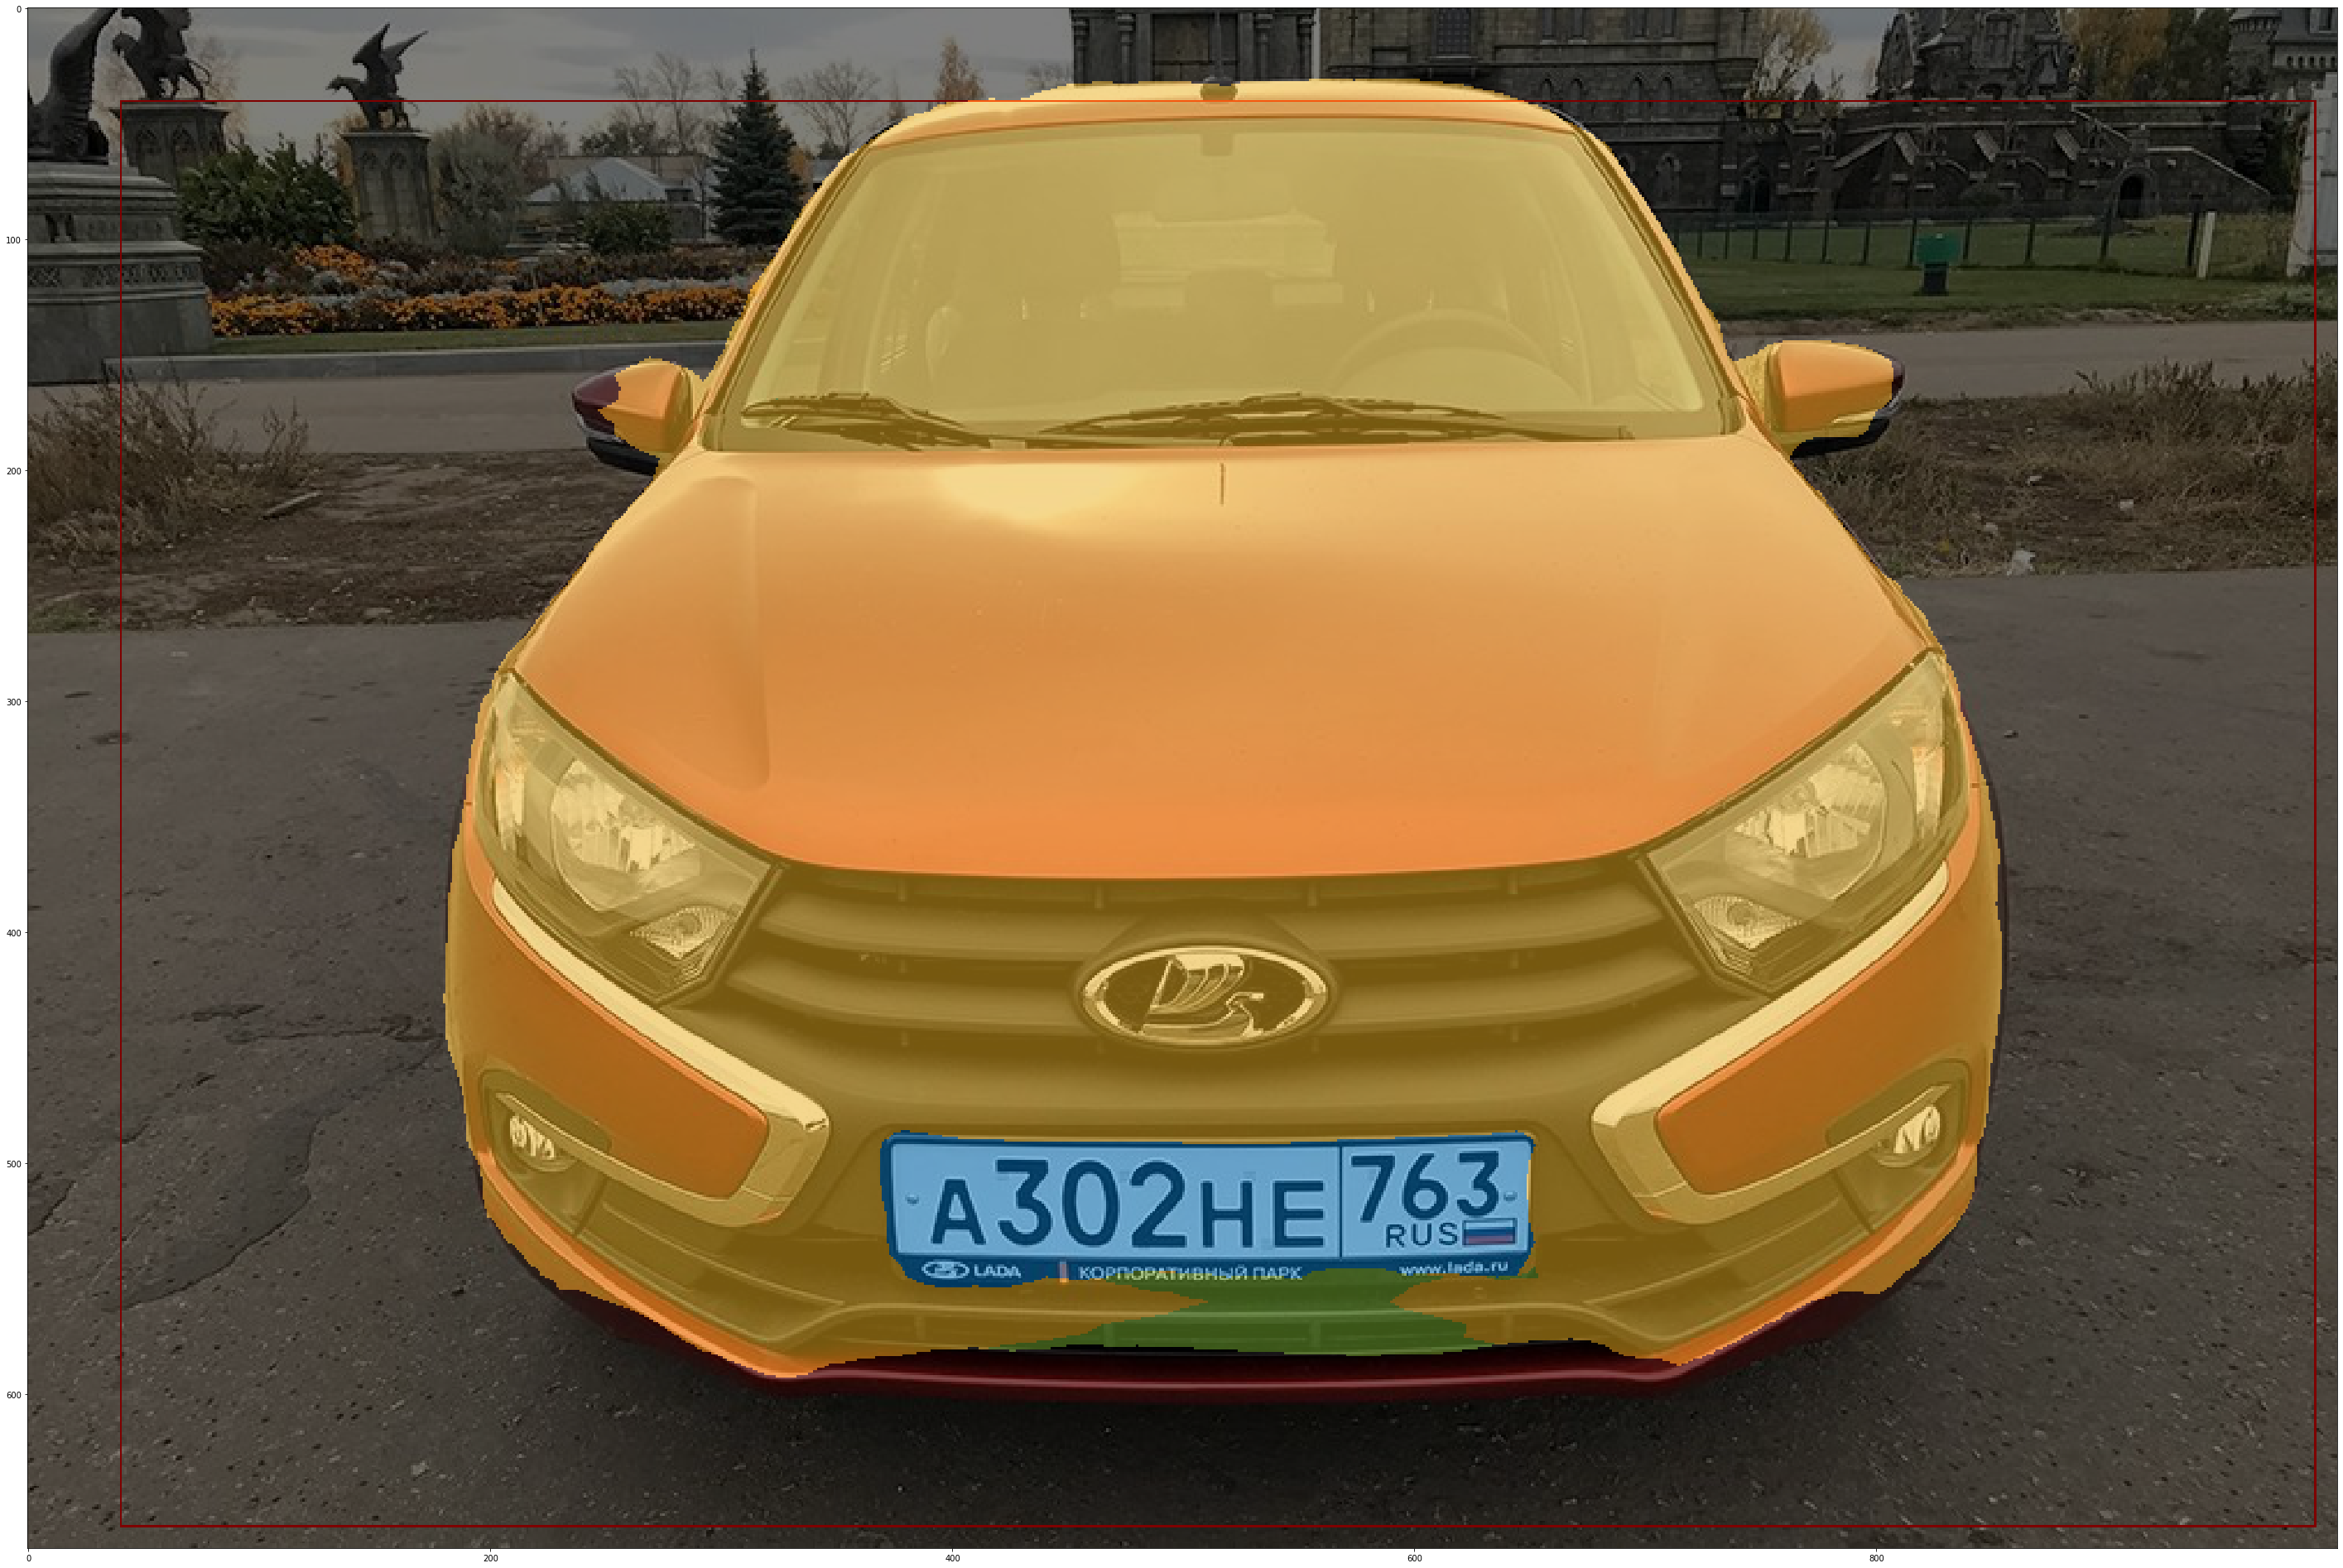

In [47]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,80)
pred_img, color_seg = get_seg_overlay(image, pred_seg)
plt.imshow(pred_img)

print(color_seg)